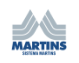

# Martins Comércio e Serviços de Distribuição S/A

In [57]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, ParameterGrid

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc

import os
print('LOCAL DE DATASETS')
print()
for dirname, _, filenames in os.walk('/Meus documentos/Projetos/martins/database'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

LOCAL DE DATASETS

/Meus documentos/Projetos/martins/database\BaseTeste_DataScience.xlsx


***
# - Objetivo

### 1) Desenvolver um modelo de predição que seja capaz de classificar o cliente em algum segmento de acordo com o seu perfil de compras

#### DICIONÁRIO DE DADOS:

**CODCLIEND**: Código identificador do cliente

**DESUNDNGCCLI**: Segmento do cliente (target)

**ValorVenda_...**: Valor de venda de cada categoria de produtos compradas pelos clientes.

**Obs**: valores nulos significam que o cliente não comprou nenhum produto daquela categoria.


***
## 1.1) Entendendo o Negócio

***
## 1.2) Coleta de dados

In [2]:
df = pd.read_excel('database/BaseTeste_DataScience.xlsx', sheet_name='Dataset Completo')
df

,CODCLIEND,DESUNDNGCCLI,ValorVenda_BAZAR,ValorVenda_LIMPEZA,ValorVenda_MERCEARIA DOCE,ValorVenda_AGROVETERINARIOS,ValorVenda_EQUIPAMENTOS INSTITUC,ValorVenda_MATERIAL CONSTRUCAO,ValorVenda_MATERIAL ELETRICO,ValorVenda_CALCADOS,...,ValorVenda_TINTAS E ACESSORIOS,ValorVenda_IMPLEMENTOS AGROPECUA,ValorVenda_ESCOLARES/ESCRITORIO,ValorVenda_PROMOCIONAIS - BRINDE,ValorVenda_BEBIDAS ALCOOLICAS,ValorVenda_EPI,ValorVenda_PUERICULTURA,ValorVenda_MOVEIS/COLCHOES,ValorVenda_AGROQUIMICO,ValorVenda_LIVRARIA
0,17,VAREJO ALIMENTAR,1020.23,79.08,292.20,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51,VAREJO ALIMENTAR,NaN,NaN,249.90,371.44,1180.88,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,89,VAREJO ALIMENTAR,NaN,NaN,NaN,NaN,NaN,1238.86,2730.42,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,97,VAREJO ALIMENTAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1482.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,125,VAREJO ALIMENTAR,NaN,91.99,363.96,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114783,7667493,VAREJO ALIMENTAR,NaN,NaN,362.30,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114784,7667494,VAREJO ALIMENTAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,772.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114785,7667495,ELETRO,433.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114786,7667497,MARTCON,NaN,NaN,NaN,NaN,NaN,NaN,340.62,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


***
## 1.3) Limpeza dos dados

In [3]:
def just_check_nan(df):
    # Check NaN Pandas and Numpy
    missing_val_count_by_column = (df.isna().sum())

    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

In [4]:
just_check_nan(df)

Dados com NaN:
ValorVenda_BAZAR                     81528
ValorVenda_LIMPEZA                   77412
ValorVenda_MERCEARIA DOCE            73344
ValorVenda_AGROVETERINARIOS         100675
ValorVenda_EQUIPAMENTOS INSTITUC    111964
ValorVenda_MATERIAL CONSTRUCAO       83105
ValorVenda_MATERIAL ELETRICO         92072
ValorVenda_CALCADOS                  89153
ValorVenda_HIGIENE                   64342
ValorVenda_MERCEARIA SALGADA         88998
ValorVenda_BELEZA                    87680
ValorVenda_ELETRO                   100858
ValorVenda_TELECOM                  112360
ValorVenda_AUTOMOTIVOS              108643
ValorVenda_BEBIDAS NAO ALCOOLICA    104125
ValorVenda_FERRAGEM                 105173
ValorVenda_FERRAMENTAS              101063
ValorVenda_INFORMATICA              108359
ValorVenda_MATERIAL HIDRAULICO      106152
ValorVenda_TINTAS E ACESSORIOS      105688
ValorVenda_IMPLEMENTOS AGROPECUA    106689
ValorVenda_ESCOLARES/ESCRITORIO     109832
ValorVenda_PROMOCIONAIS - BRINDE    114

In [5]:
# df = df.fillna(0)
# df

## Porém, devemos lembrar que valores nulos significam que o cliente não comprou nenhum produto daquela categoria!!

A unica categoria que DEVEMOS ficar atentos para que não haja dados faltantes é a categoria 'DESUNDNGCCLI'. Não está listada

***
## 1.4) Exploração dos dados

Os seus dados são suficientes para responder questionamentos?

Verificar se há dados suficientes para responder seus questionamentos

Criar um esboço para testar sua solução e futuras validações

#### Mostrar as colunas do database

In [6]:
columns = df.columns
columns

Index(['CODCLIEND', 'DESUNDNGCCLI', 'ValorVenda_BAZAR', 'ValorVenda_LIMPEZA',
       'ValorVenda_MERCEARIA DOCE', 'ValorVenda_AGROVETERINARIOS',
       'ValorVenda_EQUIPAMENTOS INSTITUC', 'ValorVenda_MATERIAL CONSTRUCAO',
       'ValorVenda_MATERIAL ELETRICO', 'ValorVenda_CALCADOS',
       'ValorVenda_HIGIENE', 'ValorVenda_MERCEARIA SALGADA',
       'ValorVenda_BELEZA', 'ValorVenda_ELETRO', 'ValorVenda_TELECOM',
       'ValorVenda_AUTOMOTIVOS', 'ValorVenda_BEBIDAS NAO ALCOOLICA',
       'ValorVenda_FERRAGEM', 'ValorVenda_FERRAMENTAS',
       'ValorVenda_INFORMATICA', 'ValorVenda_MATERIAL HIDRAULICO',
       'ValorVenda_TINTAS E ACESSORIOS', 'ValorVenda_IMPLEMENTOS AGROPECUA',
       'ValorVenda_ESCOLARES/ESCRITORIO', 'ValorVenda_PROMOCIONAIS - BRINDE',
       'ValorVenda_BEBIDAS ALCOOLICAS', 'ValorVenda_EPI',
       'ValorVenda_PUERICULTURA', 'ValorVenda_MOVEIS/COLCHOES',
       'ValorVenda_AGROQUIMICO', 'ValorVenda_LIVRARIA'],
      dtype='object')

### Variaveis categoricas

In [7]:
# Get list of categorical variables
s = (df.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables: ", len(object_cols))
print(object_cols)

Categorical variables:  1
['DESUNDNGCCLI']


### Variaveis numéricas

In [8]:
# Criando uma lista de variaveis numéricas
numerical_cols = [cname for cname in df[columns[1:-1]].columns if df[columns[1:-1]][cname].dtype in ['int64', 'float64']] # df[columns[1:-1]] já exclui feature 'CODCLIEND'
print("Numerical variables: ", len(numerical_cols))
print(numerical_cols)

Numerical variables:  28
['ValorVenda_BAZAR', 'ValorVenda_LIMPEZA', 'ValorVenda_MERCEARIA DOCE', 'ValorVenda_AGROVETERINARIOS', 'ValorVenda_EQUIPAMENTOS INSTITUC', 'ValorVenda_MATERIAL CONSTRUCAO', 'ValorVenda_MATERIAL ELETRICO', 'ValorVenda_CALCADOS', 'ValorVenda_HIGIENE', 'ValorVenda_MERCEARIA SALGADA', 'ValorVenda_BELEZA', 'ValorVenda_ELETRO', 'ValorVenda_TELECOM', 'ValorVenda_AUTOMOTIVOS', 'ValorVenda_BEBIDAS NAO ALCOOLICA', 'ValorVenda_FERRAGEM', 'ValorVenda_FERRAMENTAS', 'ValorVenda_INFORMATICA', 'ValorVenda_MATERIAL HIDRAULICO', 'ValorVenda_TINTAS E ACESSORIOS', 'ValorVenda_IMPLEMENTOS AGROPECUA', 'ValorVenda_ESCOLARES/ESCRITORIO', 'ValorVenda_PROMOCIONAIS - BRINDE', 'ValorVenda_BEBIDAS ALCOOLICAS', 'ValorVenda_EPI', 'ValorVenda_PUERICULTURA', 'ValorVenda_MOVEIS/COLCHOES', 'ValorVenda_AGROQUIMICO']


### Mostrando a correlação entre os dados numéricos, excluindo codigo do cliente que ficará de fora do treinamento do modelo

<AxesSubplot:>

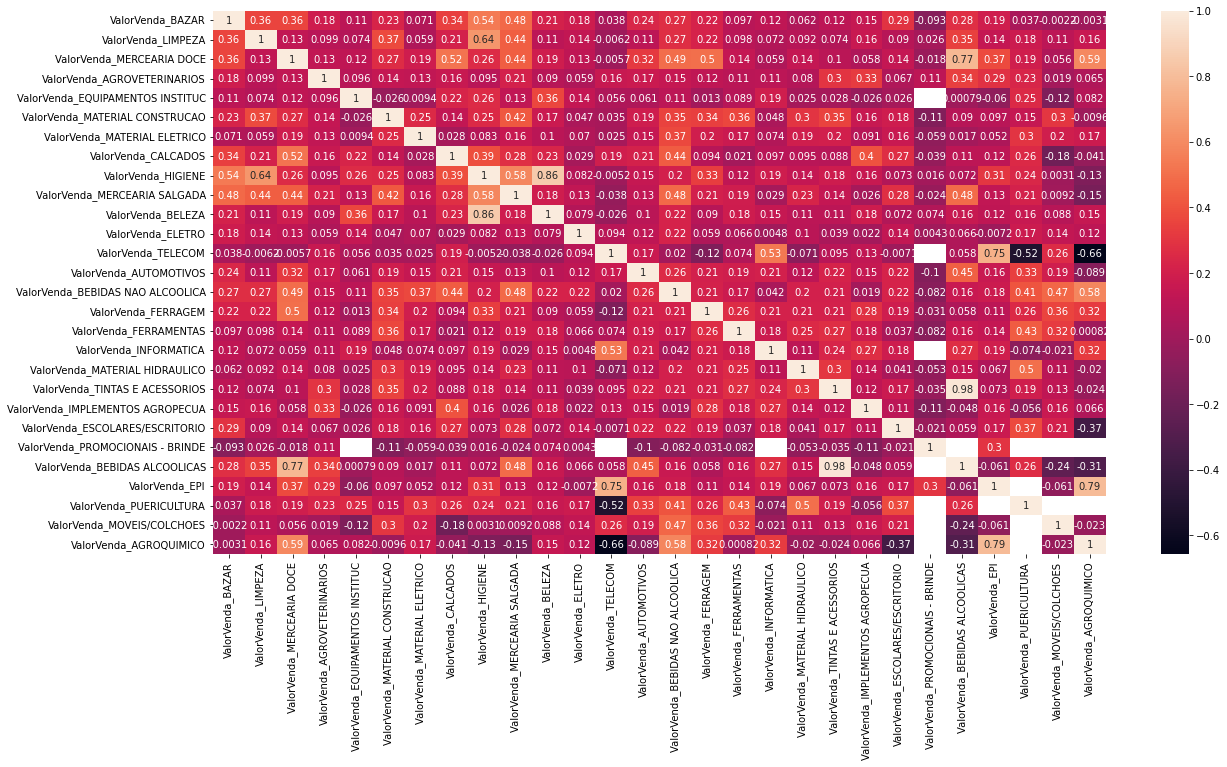

In [9]:
corr = df[columns[2:-1]].corr()

fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True)

## Distinguir se há codigo de clientes repetidos

In [10]:
print('Do total de', len(df), 'clientes na base de dados, há', len(df['CODCLIEND'].unique()), 'clientes diferentes, ou seja, não há repetição de clientes nesta base')


Do total de 114788 clientes na base de dados, há 114788 clientes diferentes, ou seja, não há repetição de clientes nesta base


## Distinguir os Segmentos do Cliente

In [11]:
print('A quantidade de Segmentos do Cliente são', len(df['DESUNDNGCCLI'].unique()), 'e esses são:', df['DESUNDNGCCLI'].unique())


A quantidade de Segmentos do Cliente são 6 e esses são: ['VAREJO ALIMENTAR' 'ELETRO' 'MARTCON' 'VETERINARIO' 'FARMA NACIONAL'
 'INFORMATICA']


## Perfis de compra

In [12]:
print('Os perfis de compra do cliente são:')
print(columns[2:-1])


Os perfis de compra do cliente são:
Index(['ValorVenda_BAZAR', 'ValorVenda_LIMPEZA', 'ValorVenda_MERCEARIA DOCE',
       'ValorVenda_AGROVETERINARIOS', 'ValorVenda_EQUIPAMENTOS INSTITUC',
       'ValorVenda_MATERIAL CONSTRUCAO', 'ValorVenda_MATERIAL ELETRICO',
       'ValorVenda_CALCADOS', 'ValorVenda_HIGIENE',
       'ValorVenda_MERCEARIA SALGADA', 'ValorVenda_BELEZA',
       'ValorVenda_ELETRO', 'ValorVenda_TELECOM', 'ValorVenda_AUTOMOTIVOS',
       'ValorVenda_BEBIDAS NAO ALCOOLICA', 'ValorVenda_FERRAGEM',
       'ValorVenda_FERRAMENTAS', 'ValorVenda_INFORMATICA',
       'ValorVenda_MATERIAL HIDRAULICO', 'ValorVenda_TINTAS E ACESSORIOS',
       'ValorVenda_IMPLEMENTOS AGROPECUA', 'ValorVenda_ESCOLARES/ESCRITORIO',
       'ValorVenda_PROMOCIONAIS - BRINDE', 'ValorVenda_BEBIDAS ALCOOLICAS',
       'ValorVenda_EPI', 'ValorVenda_PUERICULTURA',
       'ValorVenda_MOVEIS/COLCHOES', 'ValorVenda_AGROQUIMICO'],
      dtype='object')


### Exibindo frequência com que o Segmentos do Cliente ocorre no database

In [13]:
def plot_feature_freq(df, feature, qt_cat):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)

    # ordena pelas mais frequentes
    order = np.argsort(counts)[::-1]
    labels, counts = labels[order], counts[order]

    g = sns.barplot(labels[:qt_cat], counts[:qt_cat])
    g.set_xticklabels(labels[:qt_cat], rotation=30)
    
    return g

<AxesSubplot:>

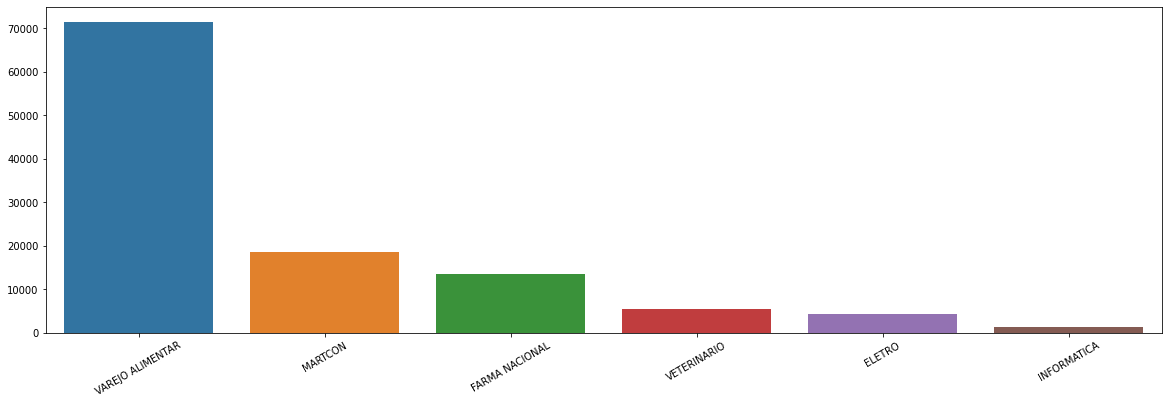

In [14]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(df, 'DESUNDNGCCLI', len(df['DESUNDNGCCLI'].unique()))

In [15]:
segmentos = Counter(df['DESUNDNGCCLI'])

for elem in segmentos:  # update counts from an iterable
    print('Segmento ' + elem + ' possui %.2f' %float((segmentos[elem]/len(df['DESUNDNGCCLI']))*100) + '% da base')
    print()

Segmento VAREJO ALIMENTAR possui 62.17% da base

Segmento ELETRO possui 3.84% da base

Segmento MARTCON possui 16.10% da base

Segmento VETERINARIO possui 4.86% da base

Segmento FARMA NACIONAL possui 11.83% da base

Segmento INFORMATICA possui 1.20% da base



***
# 1.5) Modelagem dos dados

#### Definição de target e features

### Target y - Como o objetivo é desenvolver um modelo de predição que seja capaz de classificar o cliente em algum segmento, nosso target y aqui é a coluna 'DESUNDNGCCLI'

In [16]:
y = df['DESUNDNGCCLI']

#### Contabilidade de classes

In [17]:
c = Counter(y)
c

Counter({'VAREJO ALIMENTAR': 71361,
         'ELETRO': 4410,
         'MARTCON': 18481,
         'VETERINARIO': 5582,
         'FARMA NACIONAL': 13576,
         'INFORMATICA': 1378})

In [18]:
for elem in c:           # update counts from an iterable
    print('Segmento ' + elem + ' possui %.2f' %float((c[elem]/len(df['DESUNDNGCCLI']))*100) + '% da base')
    print()

Segmento VAREJO ALIMENTAR possui 62.17% da base

Segmento ELETRO possui 3.84% da base

Segmento MARTCON possui 16.10% da base

Segmento VETERINARIO possui 4.86% da base

Segmento FARMA NACIONAL possui 11.83% da base

Segmento INFORMATICA possui 1.20% da base



A Classe se encontra DESBALANCEADA no segmento Informática

### Features X - E o target é baseado com o seu perfil de compras do cliente

In [19]:
X = df[columns[2:-1]]
X.columns

Index(['ValorVenda_BAZAR', 'ValorVenda_LIMPEZA', 'ValorVenda_MERCEARIA DOCE',
       'ValorVenda_AGROVETERINARIOS', 'ValorVenda_EQUIPAMENTOS INSTITUC',
       'ValorVenda_MATERIAL CONSTRUCAO', 'ValorVenda_MATERIAL ELETRICO',
       'ValorVenda_CALCADOS', 'ValorVenda_HIGIENE',
       'ValorVenda_MERCEARIA SALGADA', 'ValorVenda_BELEZA',
       'ValorVenda_ELETRO', 'ValorVenda_TELECOM', 'ValorVenda_AUTOMOTIVOS',
       'ValorVenda_BEBIDAS NAO ALCOOLICA', 'ValorVenda_FERRAGEM',
       'ValorVenda_FERRAMENTAS', 'ValorVenda_INFORMATICA',
       'ValorVenda_MATERIAL HIDRAULICO', 'ValorVenda_TINTAS E ACESSORIOS',
       'ValorVenda_IMPLEMENTOS AGROPECUA', 'ValorVenda_ESCOLARES/ESCRITORIO',
       'ValorVenda_PROMOCIONAIS - BRINDE', 'ValorVenda_BEBIDAS ALCOOLICAS',
       'ValorVenda_EPI', 'ValorVenda_PUERICULTURA',
       'ValorVenda_MOVEIS/COLCHOES', 'ValorVenda_AGROQUIMICO'],
      dtype='object')

### Dividindo as features em dados de treino e teste - 70% para dados de treinamento e 30% para dados de teste

In [20]:
# 70% for train data and 30% for test data SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.30)

### Shape dos dados

In [21]:
print('X_train.shape: ', X_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_train.shape: ', len(y_train))
print('y_test.shape: ', len(y_test))
print()
print('y_train: ', Counter(y_train))
print('y_test: ', Counter(y_test))

X_train.shape:  (80351, 28)
X_test.shape:  (34437, 28)
y_train.shape:  80351
y_test.shape:  34437

y_train:  Counter({'VAREJO ALIMENTAR': 49999, 'MARTCON': 12876, 'FARMA NACIONAL': 9502, 'VETERINARIO': 3873, 'ELETRO': 3119, 'INFORMATICA': 982})
y_test:  Counter({'VAREJO ALIMENTAR': 21362, 'MARTCON': 5605, 'FARMA NACIONAL': 4074, 'VETERINARIO': 1709, 'ELETRO': 1291, 'INFORMATICA': 396})


## Montagem do Pipeline - Só haverá alterações nos dados numéricos, pois não há dados categorios nas features

- SimpleImputer - mudará (fill) todos os valores NaN para 0

- StandardScaler - Normaliza os dados para valores de 0 a 1

In [22]:
numerical_transformer = Pipeline([
                                  ('imputer', SimpleImputer(strategy = 'constant', fill_value=0)),    # altera os valores ausentes NaN para 0 constante
                                  ('scaler', StandardScaler())                                        # muda valores de escala para valores menores
                                ])

In [23]:
preprocessor = ColumnTransformer(transformers=[
                                               ('num', numerical_transformer, numerical_cols),
                                              ], n_jobs=-1)

In [24]:
model = RandomForestClassifier(n_jobs=-1)

In [25]:
## Bundle preprocessing and modeling code in a pipeline
pipeline = Pipeline(steps=[
                           ('preprocessor ', preprocessor),                # Pré-processamento de pacote de dados numéricos e categóricos
                           ('smote', SMOTE(n_jobs=-1)),                    # equilibrar classes desbalanceadas
                           ('model', model)                                # modelo
                          ])

In [26]:
# Preprocessing of training data, fit model 
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor ',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ValorVenda_BAZAR',
                                                   'ValorVenda_LIMPEZA',
                                                   'ValorVenda_MERCEARIA DOCE',
                                                   'ValorVenda_AGROVETERINARIOS',
                                                   'ValorVenda_EQUIPAMENTOS '
                                     

In [27]:
# Preprocessing of validation data, get predictions
preds = pipeline.predict(X_test)

***
# Métricas

In [28]:
print('y_test: ', Counter(y_test))

y_test:  Counter({'VAREJO ALIMENTAR': 21362, 'MARTCON': 5605, 'FARMA NACIONAL': 4074, 'VETERINARIO': 1709, 'ELETRO': 1291, 'INFORMATICA': 396})


In [29]:
print('preds: ', Counter(preds))

preds:  Counter({'VAREJO ALIMENTAR': 18248, 'MARTCON': 5687, 'FARMA NACIONAL': 5017, 'VETERINARIO': 2306, 'ELETRO': 2153, 'INFORMATICA': 1026})


### Matrix Confusion

In [30]:
cm_df = pd.DataFrame(confusion_matrix(y_test, preds), index = sorted(Counter(y_test)), columns = sorted(Counter(preds)))
cm_df

#Valores Reais  /                                Valores Previstos

,ELETRO,FARMA NACIONAL,INFORMATICA,MARTCON,VAREJO ALIMENTAR,VETERINARIO
ELETRO,645,52,178,116,231,69
FARMA NACIONAL,114,2891,52,41,903,73
INFORMATICA,107,9,209,20,44,7
MARTCON,235,38,112,4252,419,549
VAREJO ALIMENTAR,977,1988,445,897,16366,689
VETERINARIO,75,39,30,361,285,919


### Classification Report

In [31]:
print(classification_report(y_test, preds))

                  precision    recall  f1-score   support

          ELETRO       0.30      0.50      0.37      1291
  FARMA NACIONAL       0.58      0.71      0.64      4074
     INFORMATICA       0.20      0.53      0.29       396
         MARTCON       0.75      0.76      0.75      5605
VAREJO ALIMENTAR       0.90      0.77      0.83     21362
     VETERINARIO       0.40      0.54      0.46      1709

        accuracy                           0.73     34437
       macro avg       0.52      0.63      0.56     34437
    weighted avg       0.78      0.73      0.75     34437



### AUC

**AUC** representa grau ou medida de separabilidade.
* Quanto maior a **AUC**, melhor o modelo em prever as classes, por ex: 0s como 0s e 1s como 1s


* Um **modelo excelente tem AUC perto do 1**, o que significa que ele tem uma boa medida de separabilidade. 
* Um **modelo que tem AUC é 0,7** significa que há 70% de chance de que o modelo seja capaz de distinguir entre as classe.
* Um **modelo não tem capacidade de separação de classes tem AUC é 0,5**
* Um **modelo ruim tem AUC perto do 0**, o que significa que ele tem a pior medida de separabilidade.

In [32]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_test_ohe = pd.DataFrame(OH_encoder.fit_transform(pd.DataFrame(y_test)))
preds_ohe = pd.DataFrame(OH_encoder.fit_transform(pd.DataFrame(preds)))

# calculate AUC
aucur = roc_auc_score(y_test_ohe, preds_ohe, multi_class='ovr')
print('AUC: %.3f' % aucur)

AUC: 0.785


### Curva ROC

ROC é uma curva de probabilidade, quão bem seu classificador pode separar as CLASSES e para identificar o melhor limite para separá-los

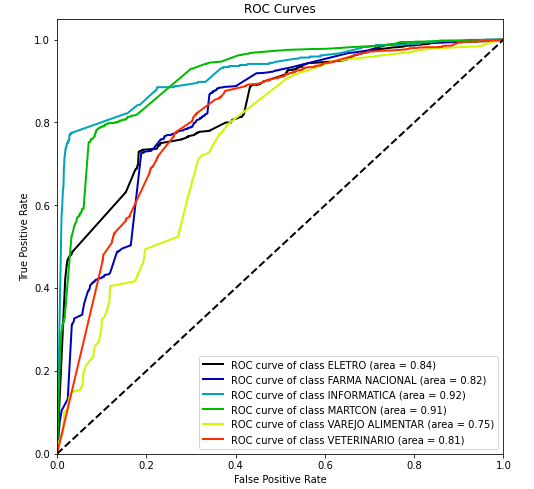

***

### 2) Com o modelo obtido, identificar o perfil de consumo de categorias em cada segmento.

perfil de consumo de categoria

	por segmento

***
### Segmento VAREJO ALIMENTAR


#### A partir dos segmentos previstos pelo modelo, extrai o perfil de consumo dos clientes

In [33]:
# var_ali = df.loc[df['DESUNDNGCCLI'] == 'VAREJO ALIMENTAR']
# var_ali = var_ali.drop(['CODCLIEND', 'DESUNDNGCCLI'], axis=1)
# # # var_ali

In [59]:
# a partir dos segmentos previstos pelo modelo, extrai o perfil de consumo dos clientes
var_ali = X_test.loc[preds == 'VAREJO ALIMENTAR']
# var_ali

### Somar a quantidade de colunas sem NaN

In [35]:
qty_var_ali = len(var_ali) - var_ali.isna().sum().sort_values(ascending=True)
# qty_var_ali

### Gráfico do perfil de consumo de categorias em cada segmento

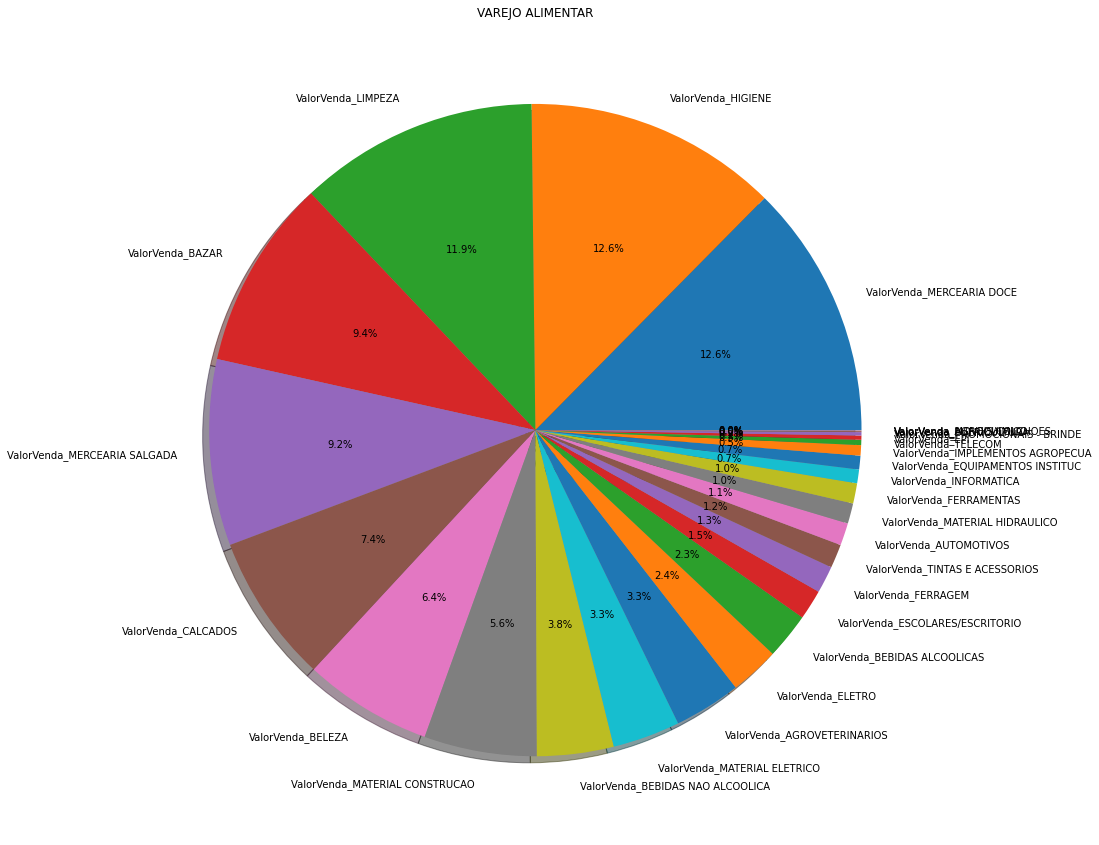

In [36]:
# define o nível de separabilidade entre as partes, ordem do vetor representa as partes
plt.subplots(figsize=(15,15))

plt.pie(qty_var_ali, labels=qty_var_ali.index, autopct='%1.1f%%', shadow=True)
plt.title('VAREJO ALIMENTAR')
plt.show()

***
### Segmento ELETRO

In [37]:
# var_ele = df.loc[df['DESUNDNGCCLI'] == 'ELETRO']
# var_ele = var_ele.drop(['CODCLIEND', 'DESUNDNGCCLI'], axis=1)
# # var_ele

In [38]:
var_ele = X_test.loc[preds == 'ELETRO']
# var_ele

### Somar a quantidade de colunas sem NaN

In [39]:
qty_var_ele = len(var_ele) - var_ele.isna().sum().sort_values(ascending=True)
# qty_var_ele

### Gráfico do perfil de consumo de categorias em cada segmento

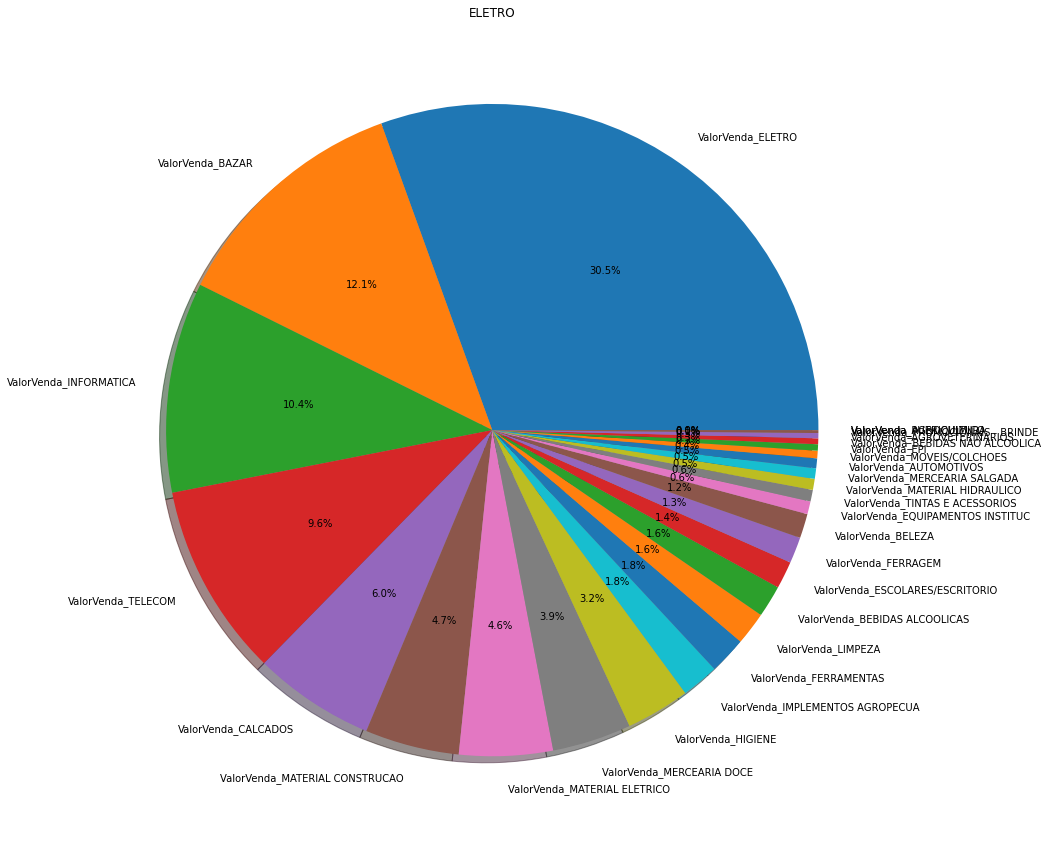

In [40]:
# define o nível de separabilidade entre as partes, ordem do vetor representa as partes
plt.subplots(figsize=(15,15))

plt.pie(qty_var_ele, labels=qty_var_ele.index, autopct='%1.1f%%', shadow=True)
plt.title('ELETRO')
plt.show()

***
### Segmento MARTCON

In [41]:
# var_mrt = df.loc[df['DESUNDNGCCLI'] == 'MARTCON']
# var_mrt = var_mrt.drop(['CODCLIEND', 'DESUNDNGCCLI'], axis=1)
# # var_mrt

In [42]:
var_mrt = X_test.loc[preds == 'MARTCON']
# var_mrt

### Somar a quantidade de colunas sem NaN

In [43]:
qty_var_mrt = len(var_mrt) - var_mrt.isna().sum().sort_values(ascending=True)
# qty_var_mrt

### Gráfico do perfil de consumo de categorias em cada segmento

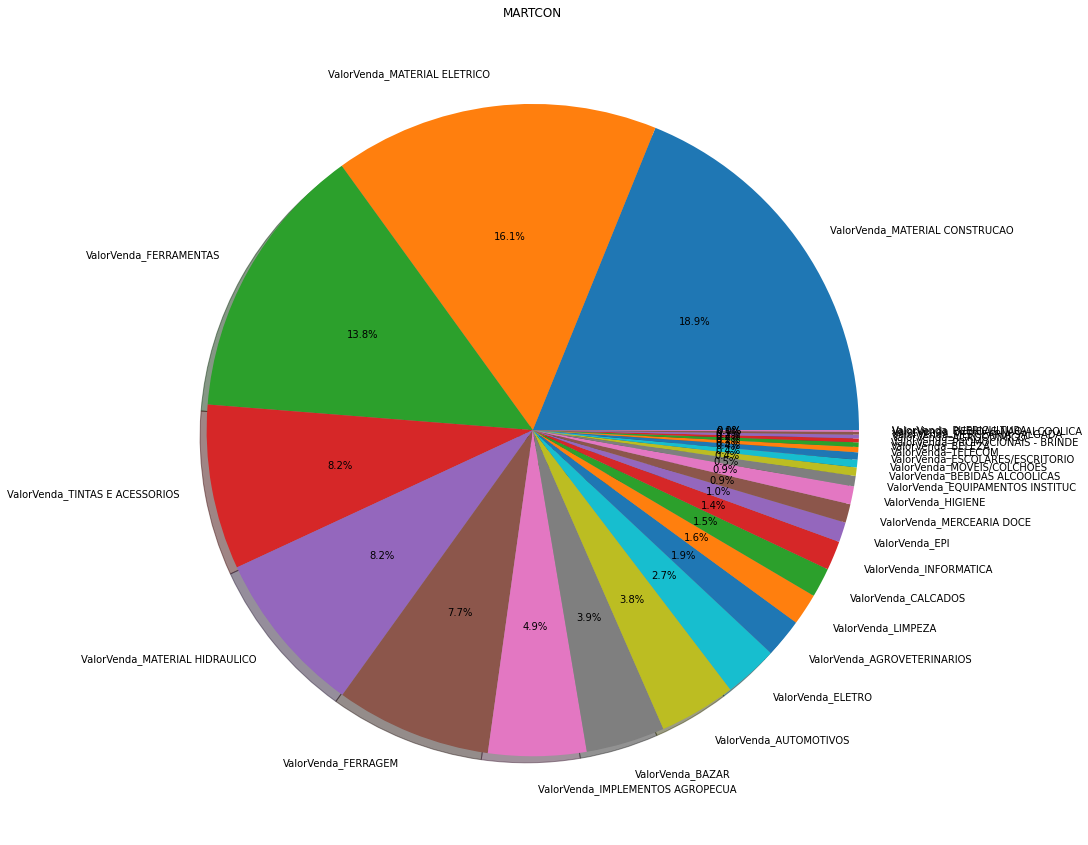

In [44]:
# define o nível de separabilidade entre as partes, ordem do vetor representa as partes
plt.subplots(figsize=(15,15))

plt.pie(qty_var_mrt, labels=qty_var_mrt.index, autopct='%1.1f%%', shadow=True)
plt.title('MARTCON')
plt.show()

***
### Segmento VETERINARIO

In [45]:
# var_vet = df.loc[df['DESUNDNGCCLI'] == 'VETERINARIO']
# var_vet = var_vet.drop(['CODCLIEND', 'DESUNDNGCCLI'], axis=1)
# # var_vet

In [46]:
var_vet = X_test.loc[preds == 'VETERINARIO']
# var_vet

### Somar a quantidade de colunas sem NaN

In [47]:
qty_var_vet = len(var_vet) - var_vet.isna().sum().sort_values(ascending=True)
# qty_var_vet

### Gráfico do perfil de consumo de categorias em cada segmento

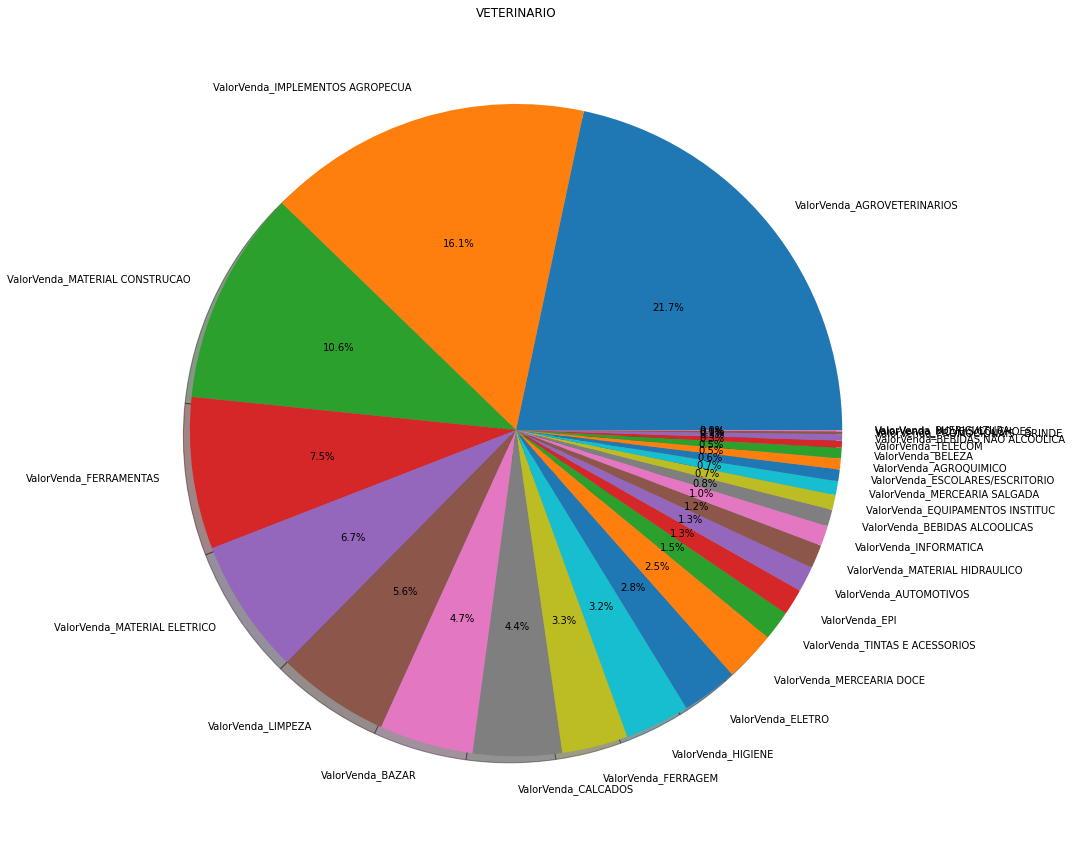

In [48]:
# define o nível de separabilidade entre as partes, ordem do vetor representa as partes
plt.subplots(figsize=(15,15))

plt.pie(qty_var_vet, labels=qty_var_vet.index, autopct='%1.1f%%', shadow=True)
plt.title('VETERINARIO')
plt.show()

***
### Segmento FARMA NACIONAL

In [49]:
# var_far = df.loc[df['DESUNDNGCCLI'] == 'FARMA NACIONAL']
# var_far = var_far.drop(['CODCLIEND', 'DESUNDNGCCLI'], axis=1)
# # var_far

In [50]:
var_far = X_test.loc[preds == 'FARMA NACIONAL']
# var_far

### Somar a quantidade de colunas sem NaN

In [51]:
qty_var_far = len(var_far) - var_far.isna().sum().sort_values(ascending=True)
# qty_var_far

### Gráfico do perfil de consumo de categorias em cada segmento

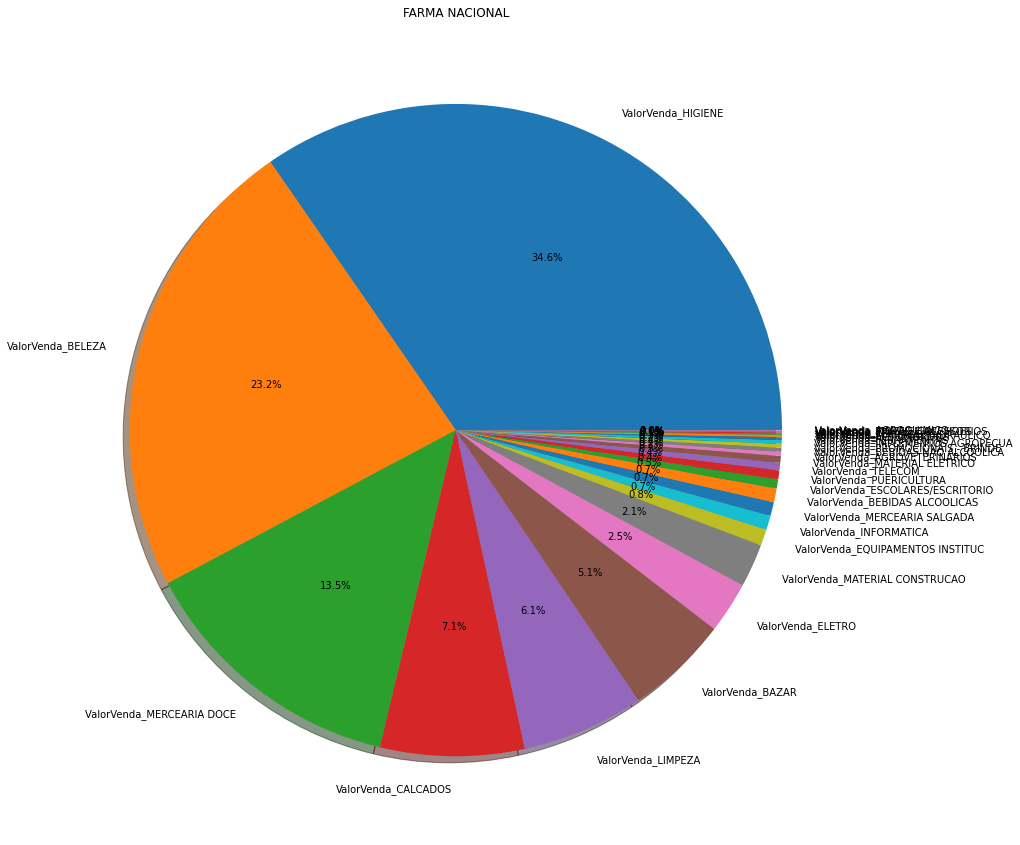

In [52]:
# define o nível de separabilidade entre as partes, ordem do vetor representa as partes
plt.subplots(figsize=(15,15))

plt.pie(qty_var_far, labels=qty_var_far.index, autopct='%1.1f%%', shadow=True)
plt.title('FARMA NACIONAL')
plt.show()

***
### Segmento INFORMATICA

In [53]:
# var_inf = df.loc[df['DESUNDNGCCLI'] == 'INFORMATICA']
# var_inf = var_inf.drop(['CODCLIEND', 'DESUNDNGCCLI'], axis=1)
# # var_inf

In [54]:
var_inf = X_test.loc[preds == 'INFORMATICA']
# var_inf

### Somar a quantidade de colunas sem NaN

In [55]:
qty_var_inf = len(var_inf) - var_inf.isna().sum().sort_values(ascending=True)
# qty_var_inf

### Gráfico do perfil de consumo de categorias em cada segmento

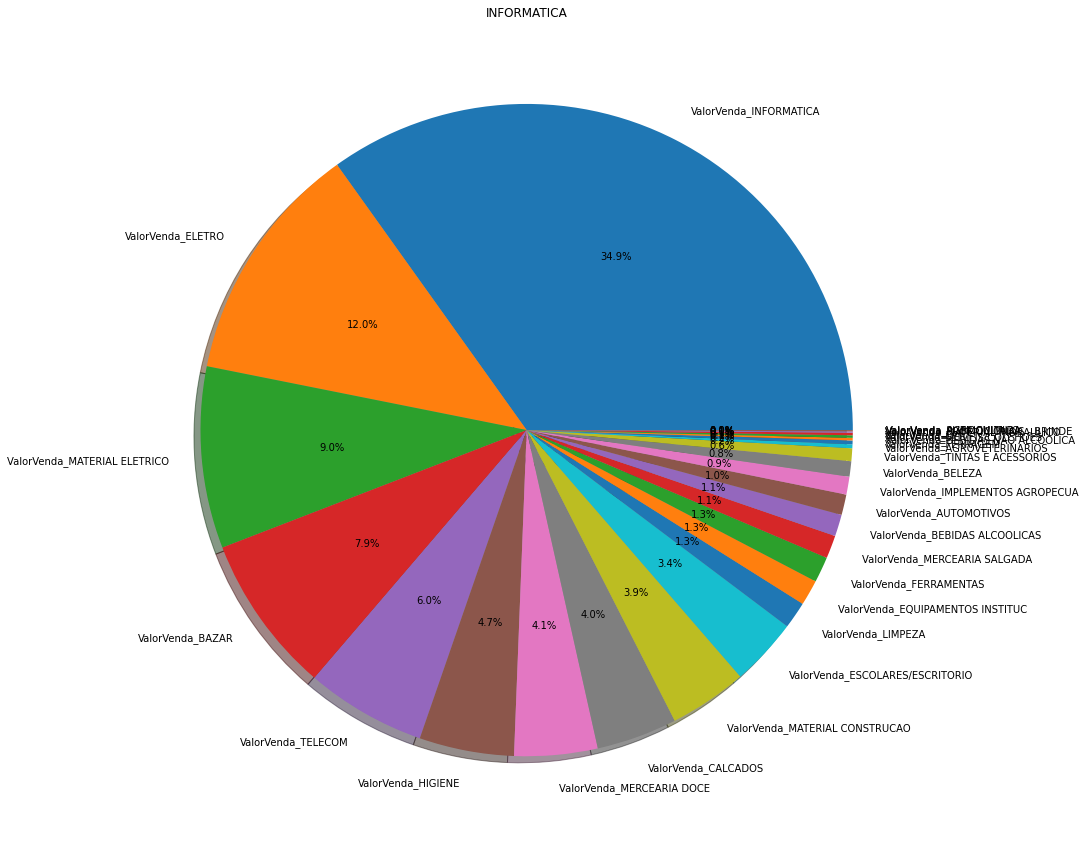

In [56]:
# define o nível de separabilidade entre as partes, ordem do vetor representa as partes
plt.subplots(figsize=(15,15))

plt.pie(qty_var_inf, labels=qty_var_inf.index, autopct='%1.1f%%', shadow=True)
plt.title('INFORMATICA')
plt.show()